## Getting data

In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 18.1MB/s 
     |████████████████████████████████| 9.5MB 51.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
!pip install arch

     |████████████████████████████████| 808kB 18.5MB/s 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [6]:
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

In [7]:
!gdown https://drive.google.com/uc?id=15j64TKndj7Yw1ixiw1DS7XmyByLIgoFt

Downloading...
From: https://drive.google.com/uc?id=15j64TKndj7Yw1ixiw1DS7XmyByLIgoFt
To: /content/INFY.csv
100% 228k/228k [00:00<00:00, 7.23MB/s]


In [8]:
data = pd.read_csv("INFY.csv")

In [9]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02-01-2004,3.023750,3.141563,2.992188,3.103125,2.222448,13360000
1,05-01-2004,3.142500,3.203125,3.132813,3.165625,2.267211,12140800
2,06-01-2004,3.130313,3.171875,3.076563,3.135938,2.245949,10416000
3,07-01-2004,3.167188,3.181250,3.048438,3.124375,2.237667,11984000
4,08-01-2004,3.156250,3.193125,3.065313,3.080625,2.206333,13427200


In [8]:
data.shape

(4026, 7)

In [10]:
data = data.set_index('Date')

In [11]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
02-01-2004,3.023750,3.141563,2.992188,3.103125,2.222448,13360000
05-01-2004,3.142500,3.203125,3.132813,3.165625,2.267211,12140800
06-01-2004,3.130313,3.171875,3.076563,3.135938,2.245949,10416000
07-01-2004,3.167188,3.181250,3.048438,3.124375,2.237667,11984000
08-01-2004,3.156250,3.193125,3.065313,3.080625,2.206333,13427200


In [11]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Closing stock 2004')

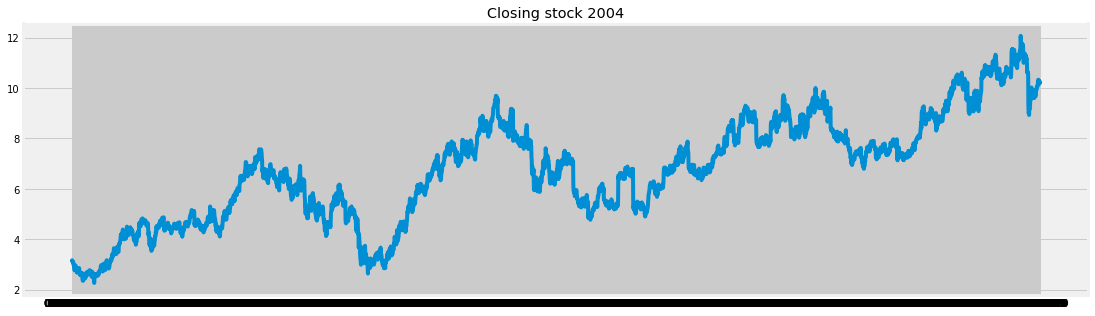

In [ ]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data['Close'])
plt.title("Closing stock 2004")

Text(0.5, 1.0, 'Number of Stocks sold since 2004')

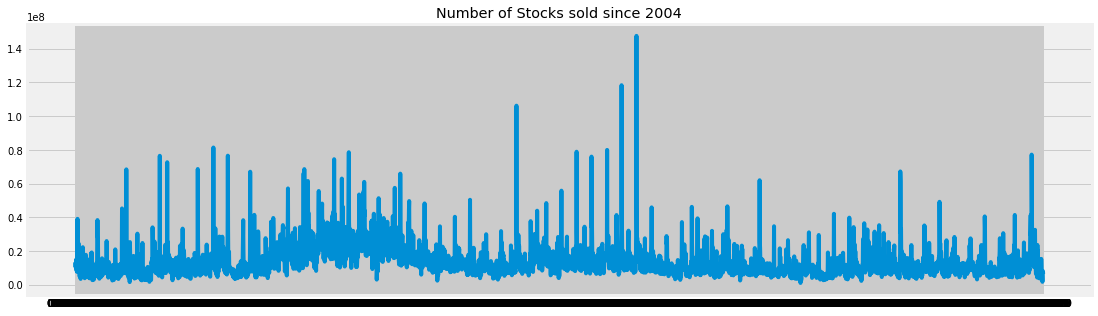

In [ ]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data['Volume'])
plt.title("Number of Stocks sold since 2004")

In [ ]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

## Additive Seasonal Decomposition

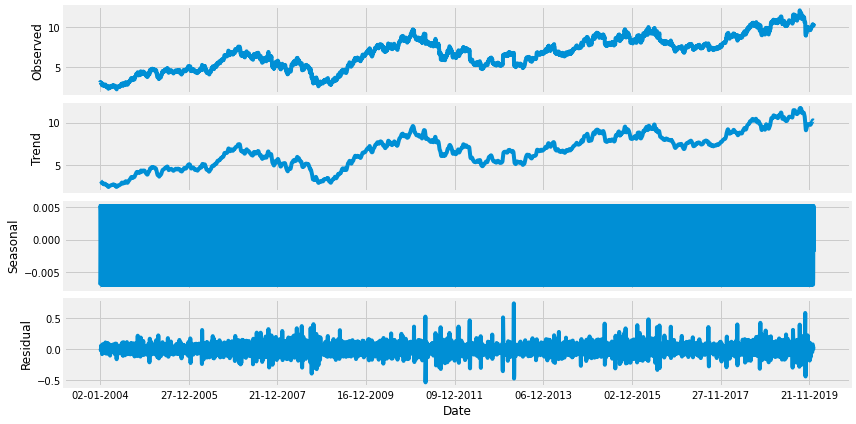

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)

decomposition = sm.tsa.seasonal_decompose(data['Close'], model='additive', freq=6)
decomposition.plot()
                                          
plt.show()

In [ ]:
print(decomposition.seasonal)

Date
02-01-2004   -0.006927
05-01-2004   -0.005927
06-01-2004    0.005215
07-01-2004    0.005052
08-01-2004    0.004442
                ...   
23-12-2019   -0.005927
24-12-2019    0.005215
26-12-2019    0.005052
27-12-2019    0.004442
30-12-2019   -0.001855
Name: Close, Length: 4026, dtype: float64


In [ ]:
print(decomposition.resid)

Date
02-01-2004         NaN
05-01-2004         NaN
06-01-2004         NaN
07-01-2004    0.007604
08-01-2004   -0.020145
                ...   
23-12-2019    0.036760
24-12-2019   -0.009382
26-12-2019         NaN
27-12-2019         NaN
30-12-2019         NaN
Name: Close, Length: 4026, dtype: float64


In [13]:
length_train = 3774
train = data.iloc[:length_train,:]      # 2004 to 2018
test = data.iloc[length_train:,: ]      # 2019

In [ ]:
print(train.shape)
print(test.shape)

(3774, 6)
(252, 6)


## Simple Average Method

In [ ]:
y_avg = test.copy()

y_avg['forecasted_avg'] = train['Close'].mean()

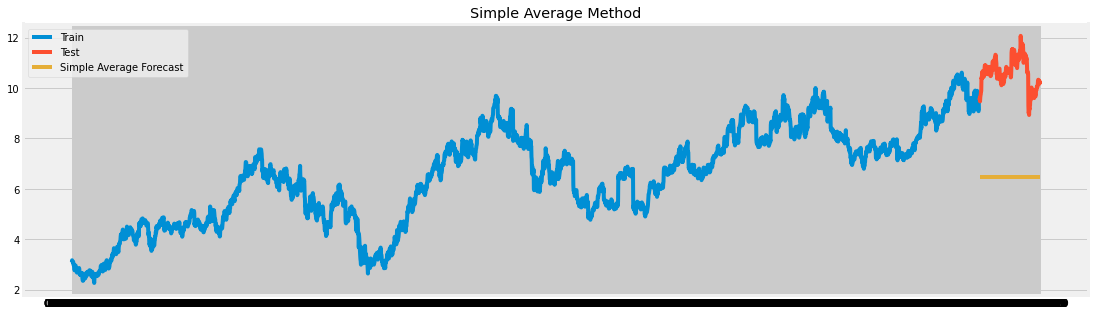

In [ ]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test')
plt.plot(y_avg['forecasted_avg'], label = 'Simple Average Forecast')

plt.legend()
plt.title('Simple Average Method')
plt.show()

In [ ]:
mse = mean_squared_error(test['Close'], y_avg['forecasted_avg'])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 4.1888


([], <a list of 0 Text major ticklabel objects>)

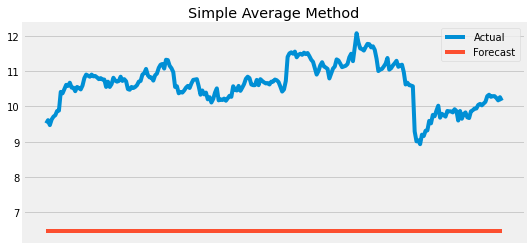

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test['Close'], label = 'Actual')
plt.plot(y_avg['forecasted_avg'], label = 'Forecast')
plt.title('Simple Average Method')
plt.legend()
plt.xticks([])

## Simple Moving Average Method

In [14]:
y_moving = data.copy()

window = 30
y_moving["moving_average_forecast"] = data['Close'].rolling(30).mean()
y_moving['moving_average_forecast'][length_train:] = y_moving['Close'][length_train-1]

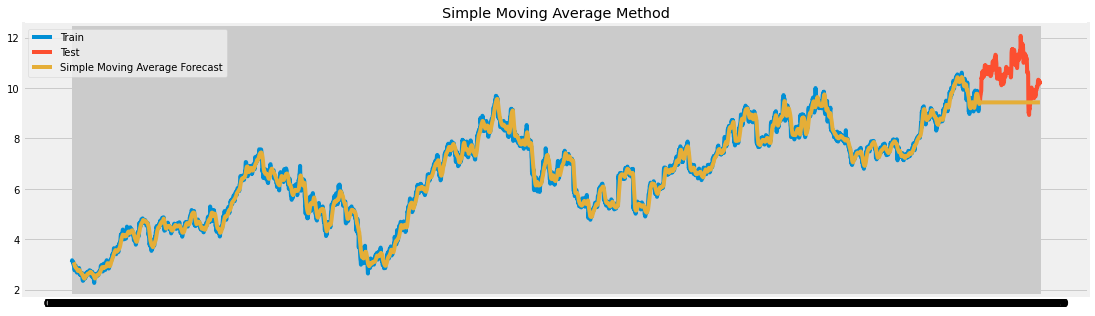

In [ ]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test')
plt.plot(y_moving['moving_average_forecast'], label = 'Simple Moving Average Forecast')

plt.legend()
plt.title('Simple Moving Average Method')
plt.show()

In [16]:
mse = mean_squared_error(test['Close'], y_moving['moving_average_forecast'][length_train:])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 1.333


([], <a list of 0 Text major ticklabel objects>)

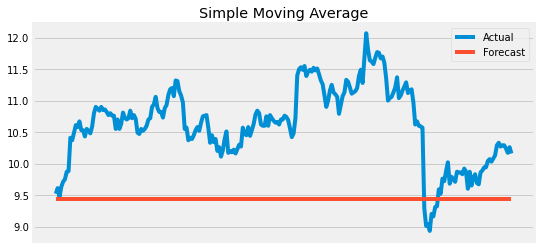

In [15]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test['Close'], label='Actual')
plt.plot(y_moving['moving_average_forecast'][length_train:], label='Forecast')
plt.legend()
plt.title('Simple Moving Average')
plt.xticks([])

## Simple Exponential Smoothing

In [ ]:
model = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.6,optimized=False)
y_exp = test.copy()
y_exp['Exponential_forecast'] = model.forecast(len(test))

In [ ]:
model.params

{'damping_trend': nan,
 'initial_level': 3.103125,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.6,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'use_boxcox': False}

In [ ]:
print(y_exp)

             Open   High    Low  ...  Adj Close   Volume  Exponential_forecast
Date                             ...                                          
31-12-2018   9.47   9.53   9.39  ...   8.998747  7229400              9.410854
02-01-2019   9.50   9.73   9.47  ...   9.083818  9818900              9.410854
03-01-2019   9.55   9.59   9.47  ...   8.951485  9404900              9.410854
04-01-2019   9.52   9.72   9.50  ...   9.102723  7119000              9.410854
07-01-2019   9.70   9.81   9.66  ...   9.178344  7732700              9.410854
...           ...    ...    ...  ...        ...      ...                   ...
23-12-2019  10.29  10.31  10.24  ...  10.039379  3500900              9.410854
24-12-2019  10.28  10.28  10.21  ...   9.990597  1730800              9.410854
26-12-2019  10.25  10.28  10.16  ...   9.922301  5815700              9.410854
27-12-2019  10.25  10.34  10.24  ...  10.010110  8082900              9.410854
30-12-2019  10.26  10.27  10.12  ...   9.912546  642

In [ ]:
print(y_exp['Exponential_forecast'])

Date
31-12-2018    9.410854
02-01-2019    9.410854
03-01-2019    9.410854
04-01-2019    9.410854
07-01-2019    9.410854
                ...   
23-12-2019    9.410854
24-12-2019    9.410854
26-12-2019    9.410854
27-12-2019    9.410854
30-12-2019    9.410854
Name: Exponential_forecast, Length: 252, dtype: float64


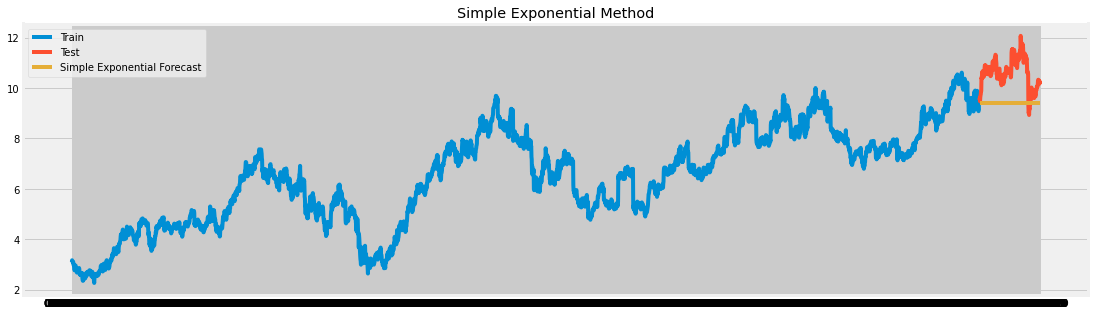

In [ ]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test')
plt.plot(y_exp['Exponential_forecast'], label = 'Simple Exponential Forecast')

plt.legend()
plt.title('Simple Exponential Method')
plt.show()

In [ ]:
mse = mean_squared_error(test['Close'], y_exp['Exponential_forecast'])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 1.3501


([], <a list of 0 Text major ticklabel objects>)

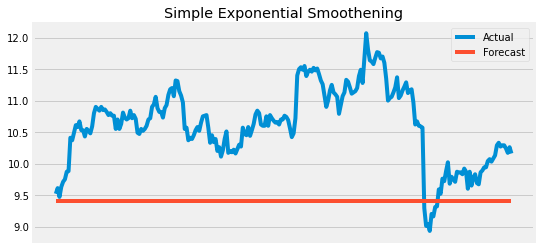

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test['Close'], label = 'Actual')
plt.plot(y_exp['Exponential_forecast'], label = 'Forecast')
plt.title('Simple Exponential Smoothening')
plt.legend()
plt.xticks([])

## Holt Winter Exponential Smoothing

In [ ]:
model = ExponentialSmoothing(np.asarray(train['Close']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_holtwinter = test.copy()
y_holtwinter['holtwinter_forecast'] = model.forecast(len(test))

In [ ]:
y_holtwinter['holtwinter_forecast']

Date
31-12-2018    9.437457
02-01-2019    9.446384
03-01-2019    9.439755
04-01-2019    9.441914
07-01-2019    9.448270
                ...   
23-12-2019    9.850383
24-12-2019    9.852542
26-12-2019    9.858897
27-12-2019    9.852832
30-12-2019    9.853139
Name: holtwinter_forecast, Length: 252, dtype: float64

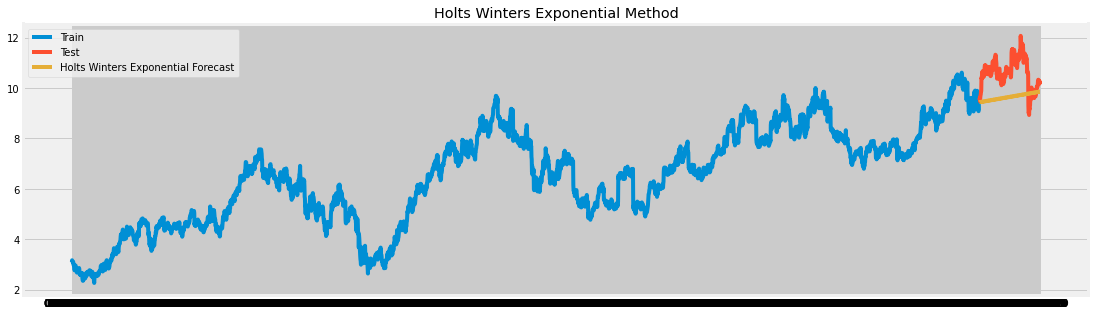

In [ ]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test')
plt.plot(y_holtwinter['holtwinter_forecast'], label = 'Holts Winters Exponential Forecast')

plt.legend()
plt.title('Holts Winters Exponential Method')
plt.show()

In [ ]:
mse = mean_squared_error(test['Close'],y_holtwinter['holtwinter_forecast'])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 1.1577


([], <a list of 0 Text major ticklabel objects>)

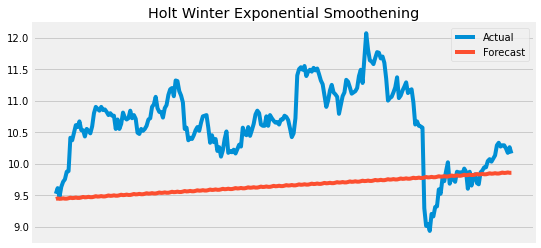

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test['Close'], label = 'Actual')
plt.plot(y_holtwinter['holtwinter_forecast'], label = 'Forecast')
plt.title('Holt Winter Exponential Smoothening')
plt.legend()
plt.xticks([])

## ADF Test for Stationarity checking

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
02-01-2004,3.023750,3.141563,2.992188,3.103125,2.222448,13360000
05-01-2004,3.142500,3.203125,3.132813,3.165625,2.267211,12140800
06-01-2004,3.130313,3.171875,3.076563,3.135938,2.245949,10416000
07-01-2004,3.167188,3.181250,3.048438,3.124375,2.237667,11984000
08-01-2004,3.156250,3.193125,3.065313,3.080625,2.206333,13427200


In [ ]:
data_copy = data.copy()

In [ ]:
data_copy['Returns'] = data_copy['Close'].pct_change()
data_copy.dropna(how='any', inplace=True)

In [ ]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ", dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(data_copy['Returns'])

1. ADF :  -15.98903402820041
2. P-Value :  6.703376923101525e-29
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 4009
5. Critical Values :
	 1% :  -3.431982200554095
	 5% :  -2.8622612169156896
	 10% :  -2.5671539113677935


## KPSS test for stationarity checking

In [ ]:
def kpss_test(dataset):
  result = kpss(dataset)
  print(f'KPSS Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'num lags: {result[2]}')
  print('Critial Values:')
  for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

kpss_test(data_copy['Returns'])

KPSS Statistic: 0.06876036926178727
p-value: 0.1
num lags: 31
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


## Auto_ARIMA Function

In [ ]:
stepwise_fit = auto_arima(data_copy['Returns'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-19512.708, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-19492.313, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-19503.738, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-19505.337, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19491.903, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-19513.260, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-19515.113, Time=1.94 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-19513.157, Time=2.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-19512.560, Time=1.96 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-19510.510, Time=0.79 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-19514.018, Time=1.45 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 11.729 seconds


## ARIMA

In [ ]:
data_copy['Returns']

Date
05-01-2004    0.020141
06-01-2004   -0.009378
07-01-2004   -0.003687
08-01-2004   -0.014003
09-01-2004   -0.004463
                ...   
23-12-2019    0.000000
24-12-2019   -0.004859
26-12-2019   -0.006836
27-12-2019    0.008850
30-12-2019   -0.009747
Name: Returns, Length: 4025, dtype: float64

In [ ]:
data_copy.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns'], dtype='object')

In [ ]:
length_train = 3774
train1 = data_copy['Returns'][:length_train] # training data from 2004-2018
test1 = data_copy['Returns'][length_train:] # testing data on 2019

In [ ]:
print(train1.shape)
print(test1.shape)

(3774,)
(251,)


In [ ]:
model = ARIMA(train1, order=(0,0,2))
result = model.fit(disp=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [ ]:
step = len(test1)
fc,se,cnf = result.forecast(step)

In [ ]:
fc

array([-6.12715648e-05, -2.43098514e-05,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  5.34653634e-04,  5.34653634e-04,  5.34653634e-04,
        5.34653634e-04,  

In [ ]:
mse = mean_squared_error(test1, fc)
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 0.0153


In [ ]:
test1 = test1.reset_index(drop=True)

In [ ]:
fc=pd.Series(fc,index=test1[:step].index)
fc=fc.reset_index(drop=True)
lower=pd.Series(cnf[:,0],index=test1[:step].index)
lower=lower.reset_index(drop=True)
upper=pd.Series(cnf[:,1],index=test1[:step].index)
upper=upper.reset_index(drop=True)

In [ ]:
print(fc)

0     -0.000061
1     -0.000024
2      0.000535
3      0.000535
4      0.000535
         ...   
246    0.000535
247    0.000535
248    0.000535
249    0.000535
250    0.000535
Length: 251, dtype: float64


In [ ]:
print(lower)

0     -0.042677
1     -0.042728
2     -0.042243
3     -0.042243
4     -0.042243
         ...   
246   -0.042243
247   -0.042243
248   -0.042243
249   -0.042243
250   -0.042243
Length: 251, dtype: float64


In [ ]:
print(upper)

0      0.042554
1      0.042680
2      0.043312
3      0.043312
4      0.043312
         ...   
246    0.043312
247    0.043312
248    0.043312
249    0.043312
250    0.043312
Length: 251, dtype: float64


([], <a list of 0 Text major ticklabel objects>)

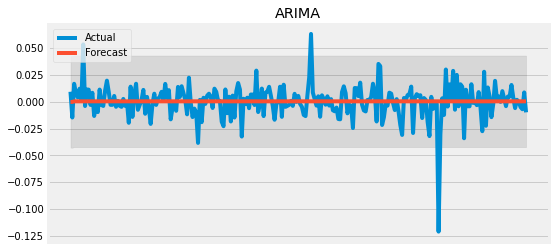

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test1[:step], label='Actual')
plt.plot(fc, label='Forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title('ARIMA')
plt.legend(loc='upper left')
plt.xticks([])

## ARCH

In [12]:
data_copy2 = data.copy()

In [13]:
data_copy2['Returns'] = 100 * data_copy2['Close'].pct_change()

In [14]:
data_copy2.dropna(how='any', inplace=True)

In [ ]:
data_copy2.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns'], dtype='object')

In [15]:
data_copy2.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
05-01-2004,3.142500,3.203125,3.132813,3.165625,2.267211,12140800,2.014099
06-01-2004,3.130313,3.171875,3.076563,3.135938,2.245949,10416000,-0.937793
07-01-2004,3.167188,3.181250,3.048438,3.124375,2.237667,11984000,-0.368725
08-01-2004,3.156250,3.193125,3.065313,3.080625,2.206333,13427200,-1.400280
09-01-2004,3.073438,3.116875,3.006250,3.066875,2.196485,15094400,-0.446338


In [ ]:
data_copy2.shape

(4025, 7)

Text(0.5, 1.0, 'Returns')

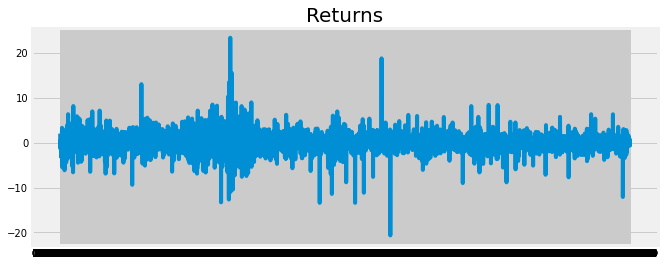

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(data_copy2['Returns'])
plt.title('Returns', fontsize=20)

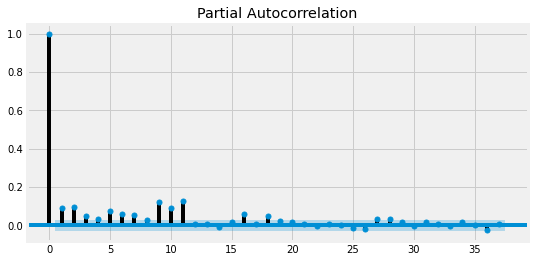

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plot_pacf(data_copy2['Returns']**2)
plt.show()

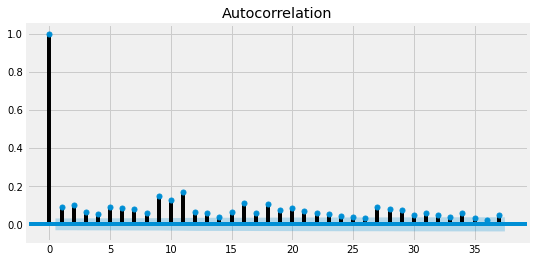

In [ ]:
plt.rcParams['figure.figsize'] = (8,4)
plot_acf(data_copy2['Returns']**2)
plt.show()

In [16]:
length_train = 3774
train2 = data_copy2['Returns'][:length_train] # training data from 2004-2018
test2 = data_copy2['Returns'][length_train:] # testing data on 2019

In [ ]:
print(train2.shape)
print(test2.shape)

(3774,)
(251,)


In [17]:
ARCH_model = arch_model(train2, mean='Zero', vol='ARCH', p=1)
ARCH_model = ARCH_model.fit()
ARCH_forecast = ARCH_model.forecast(horizon=len(test2))

Iteration:      1,   Func. Count:      4,   Neg. LLF: 8178.849913906196
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8178.149688571468
Iteration:      3,   Func. Count:     15,   Neg. LLF: 8176.801231208465
Iteration:      4,   Func. Count:     19,   Neg. LLF: 8176.536571220733
Iteration:      5,   Func. Count:     23,   Neg. LLF: 8176.533641467313
Iteration:      6,   Func. Count:     27,   Neg. LLF: 8176.53293468348
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8176.532934683374
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


In [18]:
ARCH_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8176.53
Distribution:                  Normal   AIC:                           16357.1
Method:            Maximum Likelihood   BIC:                           16369.5
                                        No. Observations:                 3774
Date:                Thu, May 06 2021   Df Residuals:                     3774
Time:                        11:27:17   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.5240      0.239     14.730  4.139e-49 [  3.055,  3.993]
alpha[1]       0.3131  9.056e-02      3.457  5.453e-04 [  0.136,  0.491]
========================================================================

Covariance estimator: robust
"""

In [19]:
mse = mean_squared_error(test2, ARCH_forecast.variance.values[-1,:])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 5.3109


([], <a list of 0 Text major ticklabel objects>)

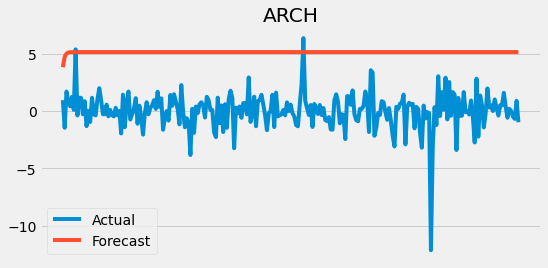

In [20]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test2, label='Actual')
plt.plot(ARCH_forecast.variance.values[-1,:], label='Forecast')
plt.title('ARCH')
plt.legend()
plt.xticks([])

## GARCH

In [21]:
GARCH_model = arch_model(train2, mean='Zero', vol='GARCH', p=1, q=1)
GARCH_fit = GARCH_model.fit()
GARCH_forecast = GARCH_fit.forecast(horizon=len(test2))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 8070.514247350345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8070.503952287496
Iteration:      3,   Func. Count:     20,   Neg. LLF: 8068.827005927222
Iteration:      4,   Func. Count:     26,   Neg. LLF: 8067.817915826601
Iteration:      5,   Func. Count:     32,   Neg. LLF: 8066.812982786014
Iteration:      6,   Func. Count:     37,   Neg. LLF: 8059.346889714847
Iteration:      7,   Func. Count:     43,   Neg. LLF: 8047.265963675729
Iteration:      8,   Func. Count:     51,   Neg. LLF: 8045.763457261055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8043.311144728416
Iteration:     10,   Func. Count:     63,   Neg. LLF: 8041.7690954659865
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8040.198227674942
Iteration:     12,   Func. Count:     75,   Neg. LLF: 8038.659793427384
Iteration:     13,   Func. Count:     81,   Neg. LLF: 8037.4341986440195
Iteration:     14,   Func. Count:     87,   Neg. LLF: 8036.273

In [22]:
GARCH_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8035.72
Distribution:                  Normal   AIC:                           16077.4
Method:            Maximum Likelihood   BIC:                           16096.2
                                        No. Observations:                 3774
Date:                Thu, May 06 2021   Df Residuals:                     3774
Time:                        11:28:13   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0229  1.079e-02      2.122  3.388e-02 [1.743e-03,4.402e-02]
alpha[1]       0.0135  2.959e-03      4.553  5.294e-06 [7.673e-03,1.927e-02]
beta[1]        0.9813  4.514e-03    217.384      0.000     [  0.972,  0.990]
============================================================================

Covariance estimator: robust
"""

In [23]:
mse = mean_squared_error(test2, GARCH_forecast.variance.values[-1,:])
rmse = np.sqrt(mse)
print("RMSE Score :", round(rmse, 4))

RMSE Score : 3.964


([], <a list of 0 Text major ticklabel objects>)

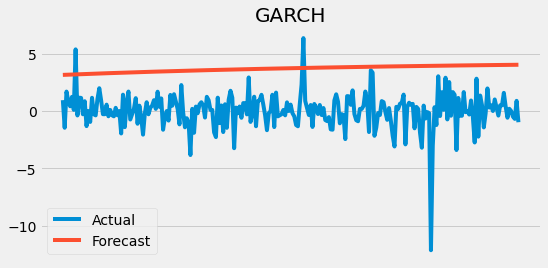

In [24]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(test2, label='Actual')
plt.plot(GARCH_forecast.variance.values[-1,:], label='Forecast')
plt.title('GARCH')
plt.legend()
plt.xticks([])